# G16 Code for creating demo data for network analysis

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import mapclassify

### 1. Peparing the economic data

#### 1.1 Load economic data

In [2]:
#Upload Bangladesh World Bank Data for to find the economic proxy.
#We use Union Council level data (Level 4)
path="../data/raw/2011-BGD-L4.csv"
df=pd.read_csv(path)

In [3]:
distname = ["Chittagong", "Dhaka","Narayanganj", "Feni","Comilla","Cox'S Bazar",
            "Brahamanbaria","Habiganj","Narsingdi","Maulvibazar","Sylhet","Noakhali"]

In [4]:
df_pop = df[(df['Level 2 name'].isin(distname)) & (df['Population density (people per sq. km.)'])]
df_pop=df_pop[['Level 2 name','Level 2 code','Level 4 name','Level 4 code','Population density (people per sq. km.)']]
df_pop.isna().sum()

Level 2 name                               0
Level 2 code                               0
Level 4 name                               0
Level 4 code                               0
Population density (people per sq. km.)    0
dtype: int64

In [5]:
df_pop.head(3)

,Level 2 name,Level 2 code,Level 4 name,Level 4 code,Population density (people per sq. km.)
1930,Brahamanbaria,2012,Ward No-01,20120201,3293.0
1931,Brahamanbaria,2012,Ward No-01,20120201,3293.0
1933,Brahamanbaria,2012,Ward No-02,20120202,2079.0


#### 1.2 Load Bangladesh shapefile

In [6]:
#read shapefile
path="../data/raw/shp/bgd_admbnda_adm4_bbs_20201113.shp"
gdf=gpd.read_file(path)

In [7]:
gdf.head(3)

,Shape_Leng,Shape_Area,ADM4_EN,ADM4_PCODE,ADM4_REF,ADM4ALT1EN,ADM4ALT2EN,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,0.286382,0.001944,Abaipur,BD40448010,None,None,None,Shailkupa,BD404480,Jhenaidah,BD4044,Khulna,BD40,Bangladesh,BD,2015-01-01,2020-11-13,NaT,"POLYGON ((89.29995 23.62161, 89.30005 23.62142..."
1,0.098597,0.000317,Abdullahpur,BD30599411,None,None,None,Tongibari,BD305994,Munshiganj,BD3059,Dhaka,BD30,Bangladesh,BD,2015-01-01,2020-11-13,NaT,"POLYGON ((90.48251 23.5537, 90.48244 23.55351,..."
2,0.170051,0.001055,Abdullapur,BD10092513,None,None,None,Char Fasson,BD100925,Bhola,BD1009,Barisal,BD10,Bangladesh,BD,2015-01-01,2020-11-13,NaT,"POLYGON ((90.70433 22.15793, 90.70435 22.15791..."


In [8]:
#Remove the BD from ADM3_PCODE column
gdf['ADM2_PCODE'] = gdf['ADM2_PCODE'].str.replace("BD", "")
gdf['ADM4_PCODE'] = gdf['ADM4_PCODE'].str.replace("BD", "")
gdf.to_crs(epsg=4326, inplace=True)


In [9]:
#gdf.head(3)

In [10]:
#gdf.plot()

<Axes: >

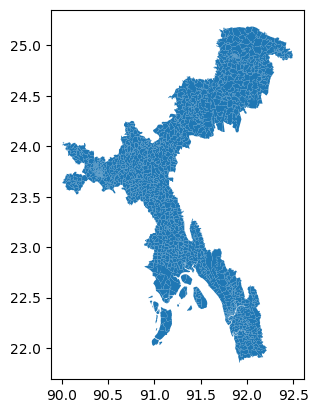

In [11]:
gdf[gdf['ADM2_EN'].isin(distname)].plot()

#### 1.3 Merge economic data with geometry

In [12]:
df_pop=df_pop.rename(columns={'Level 2 code': 'District code'})
gdf=gdf.rename(columns={'ADM2_PCODE': 'District code'})

df_pop=df_pop.rename(columns={'Level 4 code': 'Union council code'})
gdf=gdf.rename(columns={'ADM4_PCODE': 'Union council code'})
df_pop.head(3)

,Level 2 name,District code,Level 4 name,Union council code,Population density (people per sq. km.)
1930,Brahamanbaria,2012,Ward No-01,20120201,3293.0
1931,Brahamanbaria,2012,Ward No-01,20120201,3293.0
1933,Brahamanbaria,2012,Ward No-02,20120202,2079.0


In [13]:
# filter the the columns we need
gdf=gdf[['Shape_Leng', 'Shape_Area','Union council code', 'geometry']]
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Shape_Leng          5160 non-null   float64 
 1   Shape_Area          5160 non-null   float64 
 2   Union council code  5160 non-null   object  
 3   geometry            5160 non-null   geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 161.4+ KB


In [14]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4072 entries, 1930 to 23282
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Level 2 name                             4072 non-null   object 
 1   District code                            4072 non-null   int64  
 2   Level 4 name                             4072 non-null   object 
 3   Union council code                       4072 non-null   int64  
 4   Population density (people per sq. km.)  4072 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 190.9+ KB


In [15]:
# change the type of the columns to float for merging
df_pop['District code']= df_pop['District code'].astype(float)
df_pop['Union council code']= df_pop['Union council code'].astype(float)

gdf['Union council code']= gdf['Union council code'].astype(float)


In [16]:
# merge the two dataframes on the Union council code
geo_eco = gdf.merge(df_pop, on="Union council code")
geo_eco.drop_duplicates(inplace=True)

In [17]:
# align crs of the two dataframes
geo_eco.crs = gdf.crs

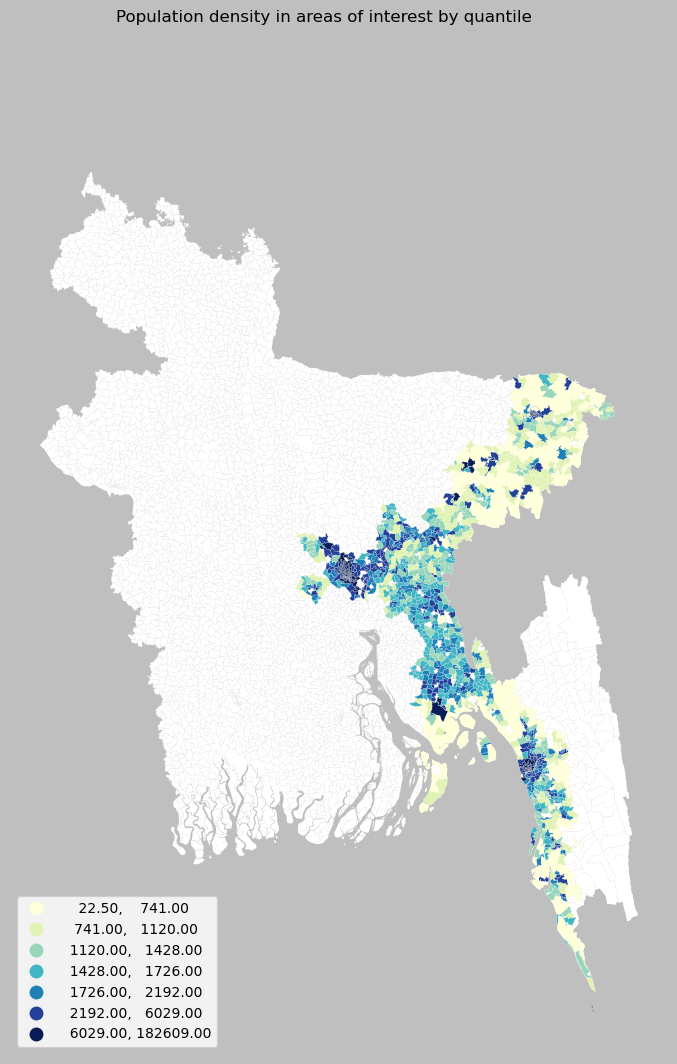

In [18]:
f, ax = plt.subplots(1, figsize=(12, 12))
# Base layer with all the areas for the background
gdf.plot(facecolor="white", linewidth=0.025, ax=ax)
geo_eco.plot(
    column="Population density (people per sq. km.)",
    scheme="QUANTILES",
    k=7,
    cmap="YlGnBu",
    alpha=1,
    edgecolor="w",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    ax=ax
)
f.set_facecolor("0.75")
ax.set_axis_off()
f.suptitle('Population density in areas of interest by quantile')
plt.savefig('../img/pop_density.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
plt.savefig('pop_density.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [20]:
geo_eco['quantile']=0
#geo_eco.head(3)

In [21]:
classifier = mapclassify.Quantiles(
    geo_eco["Population density (people per sq. km.)"],
    k=7
)
# Assign bin index to each row
geo_eco["quantile"] = classifier.yb+1

#check final dataframe
geo_eco.head(3)

,Shape_Leng,Shape_Area,Union council code,geometry,Level 2 name,District code,Level 4 name,Population density (people per sq. km.),quantile
0,0.055861,0.000172,20153311.0,"POLYGON ((91.87498 22.57881, 91.87495 22.57865...",Chittagong,2015.0,Abdullapur,2188.0,5
2,0.268927,0.001249,60367116.0,"MULTIPOLYGON (((91.29629 24.09391, 91.29639 24...",Habiganj,6036.0,Adair,1487.0,4
4,0.894030,0.009454,60585617.0,"POLYGON ((91.86054 24.33583, 91.86057 24.3357,...",Maulvibazar,6058.0,Adampur,279.0,1


### 2. Peparing the road data

In [22]:
# load road data
road=pd.read_csv('../data/processed/demo_100_with_traffic.csv')
road.head(3)


,Unnamed: 0,length,condition,lat,lon,intersection,model_type,id,road,name,chainage,traffic,truck_generation_frequency,sink_selection_probability
0,0,4.0,NaN,23.706028,90.443333,NaN,sourcesink,10000,N1,NaN,0.0040,21537.0,3.0,0.153071
1,1,1800.0,NaN,23.702383,90.451097,0,link,10001,N1,NaN,1.8040,19357.0,NaN,NaN
2,2,11.3,A,23.698739,90.458861,NaN,bridge,10002,N1,NaN,1.8153,19357.0,NaN,NaN


In [23]:
road.crs=geo_eco.crs

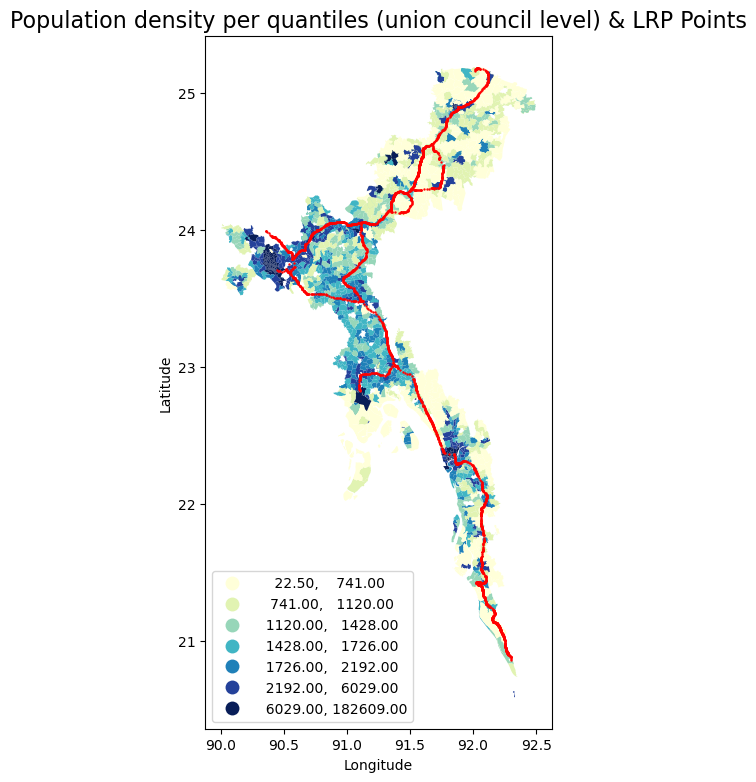

In [24]:
fig, ax = plt.subplots(figsize=(9, 9))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
# Plot the population density choropleth
geo_eco.plot(column="Population density (people per sq. km.)", scheme="Quantiles", k=7, legend=True, ax=ax, linewidth=0.25, cmap="YlGnBu")

# Scatter the LRP points (Red dots)
ax.scatter(road["lon"], road["lat"], color="red", s=0.5, label="LRP Points")

# Title
plt.title("Population density per quantiles (union council level) & LRP Points", fontsize=16)
plt.xlabel("Longitude", fontsize=10)
plt.ylabel("Latitude", fontsize=10)
plt.grid(False)
#save figure
plt.savefig('../img/pop_density_close_up.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [25]:
# Convert the LRP DataFrame to a GeoDataFrame
lrp_gdf = gpd.GeoDataFrame(
    road,
    geometry=gpd.points_from_xy(road.lon, road.lat),
    crs="EPSG:4326"  # Ensure correct coordinate reference system
)
lrp_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2837 entries, 0 to 2836
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Unnamed: 0                  2837 non-null   int64   
 1   length                      2837 non-null   float64 
 2   condition                   1376 non-null   object  
 3   lat                         2837 non-null   float64 
 4   lon                         2837 non-null   float64 
 5   intersection                1447 non-null   object  
 6   model_type                  2837 non-null   object  
 7   id                          2837 non-null   int64   
 8   road                        2837 non-null   object  
 9   name                        0 non-null      float64 
 10  chainage                    2837 non-null   float64 
 11  traffic                     2837 non-null   float64 
 12  truck_generation_frequency  14 non-null     float64 
 13  sink_selec

In [26]:
geo_eco.crs=lrp_gdf.crs
geo_eco.head(3)

,Shape_Leng,Shape_Area,Union council code,geometry,Level 2 name,District code,Level 4 name,Population density (people per sq. km.),quantile
0,0.055861,0.000172,20153311.0,"POLYGON ((91.87498 22.57881, 91.87495 22.57865...",Chittagong,2015.0,Abdullapur,2188.0,5
2,0.268927,0.001249,60367116.0,"MULTIPOLYGON (((91.29629 24.09391, 91.29639 24...",Habiganj,6036.0,Adair,1487.0,4
4,0.894030,0.009454,60585617.0,"POLYGON ((91.86054 24.33583, 91.86057 24.3357,...",Maulvibazar,6058.0,Adampur,279.0,1


### 3. Merge road data with population density data

In [27]:
# merge road data with population density data
lrp_with_pop = gpd.sjoin(lrp_gdf, geo_eco[['geometry', 'Population density (people per sq. km.)', 'quantile']], how="left", predicate="within").drop_duplicates(subset='Unnamed: 0')
lrp_with_pop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2837 entries, 0 to 2836
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Unnamed: 0                               2837 non-null   int64   
 1   length                                   2837 non-null   float64 
 2   condition                                1376 non-null   object  
 3   lat                                      2837 non-null   float64 
 4   lon                                      2837 non-null   float64 
 5   intersection                             1447 non-null   object  
 6   model_type                               2837 non-null   object  
 7   id                                       2837 non-null   int64   
 8   road                                     2837 non-null   object  
 9   name                                     0 non-null      float64 
 10  chainage                         

In [28]:
lrp_with_pop['quantile'] = lrp_with_pop['quantile'].fillna(method='ffill')

C:\Users\yaowa\AppData\Local\Temp\ipykernel_38416\4179689664.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lrp_with_pop['quantile'] = lrp_with_pop['quantile'].fillna(method='ffill')


In [29]:
#lrp_with_pop.isna().sum()

In [30]:
lrp_with_pop['quantile'].unique()

array([7., 6., 5., 2., 4., 3., 1.])

In [31]:
sorted(lrp_with_pop['quantile'].unique())

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [32]:
import numpy as np
def plot_pop_density(df_demo):
    # Create a scatter plot with traffic-based coloring
    plt.figure(figsize=(10, 8))

    quantile_levels = sorted(df_demo['quantile'].unique())

    # Create a discrete colormap with as many colors as quantile levels
    cmap = cm.get_cmap('inferno_r', len(quantile_levels))  # Discrete version of inferno_r
    boundaries = np.array(quantile_levels) - 0.5
    boundaries = np.append(boundaries, quantile_levels[-1] + 0.5)  # Add last upper bound
    norm = mcolors.BoundaryNorm(boundaries, ncolors=len(quantile_levels))

    # Plot each road
    for road in df_demo['road'].unique():
        subset = df_demo[(df_demo['road'] == road) & (df_demo['model_type'] == 'link')]
        plt.scatter(
            subset['lon'],
            subset['lat'],
            c=subset['quantile'],
            cmap=cmap,
            norm=norm,
            s=10,
            marker='o',
            label=road
        )

    ## Plot sourcesink and intersection points with different markers
    # Plot sourcesink points
    subset_sourcesink = df_demo[df_demo['model_type'] == 'sourcesink']
    plt.scatter(
        subset_sourcesink['lon'],
        subset_sourcesink['lat'],
        c='cyan',
        s=50,
        marker='s',  # Use 's' for square marker
        label='sourcesink'
    )
    # Plot intersection points
    subset_intersection = df_demo[df_demo['model_type'] == 'intersection']
    plt.scatter(
        subset_intersection['lon'],
        subset_intersection['lat'],
        c='blue',
        s=30,
        marker='o',
        label='intersection'
    )
    # Add legend for sourcesink and intersection
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[-2:], labels[-2:], loc='upper left')


    # Annotate the first data point of each road with the road name
    for road in df_demo['road'].unique():
        first_point = df_demo[df_demo['road'] == road].iloc[0]
        plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

    # Add a discrete colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Not needed for BoundaryNorm but avoids warning
    cbar = plt.colorbar(sm, ax=plt.gca(), ticks=quantile_levels)
    cbar.set_label('Population density quantile')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Network Plot with population density quantile')
    #drop grid
    plt.grid(False)
    plt.savefig('../img/Network_Plot_with_pop_quantile.png', dpi=300, bbox_inches='tight')
    # Show only the legend for sourcesink
    plt.show()

C:\Users\yaowa\AppData\Local\Temp\ipykernel_38416\3339252295.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno_r', len(quantile_levels))  # Discrete version of inferno_r


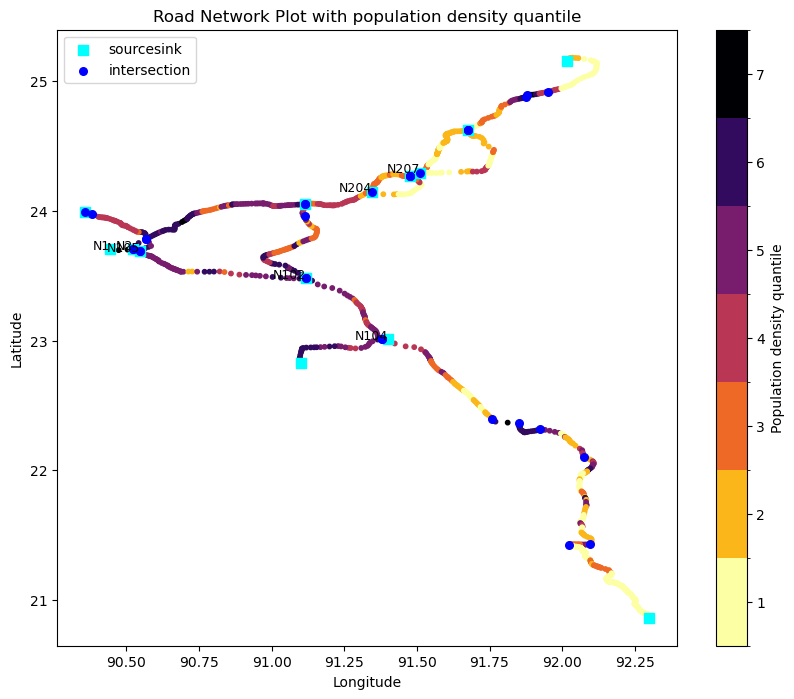

In [33]:
plot_pop_density(lrp_with_pop)

In [34]:
# Add new columns for combined length and population density with 50% weight each

# Method 1
# Normalize length column to range [0, 1]
lrp_with_pop['length_norm'] = (lrp_with_pop['length'] - lrp_with_pop['length'].min()) / (lrp_with_pop['length'].max() - lrp_with_pop['length'].min())

# Normalize quantile (1–7) to range [0, 1]
lrp_with_pop['quantile_norm'] = (lrp_with_pop['quantile'] - lrp_with_pop['quantile'].min()) / (lrp_with_pop['quantile'].max() - lrp_with_pop['quantile'].min())

# Combine with 50% weight each, with normalized length and quantile
lrp_with_pop['length_pop'] = 0.5 * lrp_with_pop['length_norm'] + 0.5 * lrp_with_pop['quantile_norm']

# Method 1
# Normalize population density to range [0, 1]
lrp_with_pop['pop_norm'] = (lrp_with_pop['Population density (people per sq. km.)'] - lrp_with_pop['Population density (people per sq. km.)'].min()) / (lrp_with_pop['Population density (people per sq. km.)'].max() - lrp_with_pop['Population density (people per sq. km.)'].min())
lrp_with_pop['pop_norm'] = lrp_with_pop['pop_norm'].fillna(method='ffill')

# Combine with 50% weight each, with normalized length and population density
lrp_with_pop['length_popden'] = 0.5 * lrp_with_pop['length_norm'] + 0.5 * lrp_with_pop['pop_norm']


C:\Users\yaowa\AppData\Local\Temp\ipykernel_38416\338032679.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lrp_with_pop['pop_norm'] = lrp_with_pop['pop_norm'].fillna(method='ffill')


In [35]:
lrp_with_pop.head(3)

,Unnamed: 0,length,condition,lat,lon,intersection,model_type,id,road,name,...,sink_selection_probability,geometry,index_right,Population density (people per sq. km.),quantile,length_norm,quantile_norm,length_pop,pop_norm,length_popden
0,0,4.0,NaN,23.706028,90.443333,NaN,sourcesink,10000,N1,NaN,...,0.153071,POINT (90.44333 23.70603),1498.0,21545.0,7.0,0.000402,1.0,0.500201,0.311098,0.155750
1,1,1800.0,NaN,23.702383,90.451097,0,link,10001,N1,NaN,...,NaN,POINT (90.4511 23.70238),755.0,68732.0,7.0,0.180850,1.0,0.590425,1.000000,0.590425
2,2,11.3,A,23.698739,90.458861,NaN,bridge,10002,N1,NaN,...,NaN,POINT (90.45886 23.69874),1498.0,21545.0,7.0,0.001135,1.0,0.500568,0.311098,0.156117


In [36]:
# Save the updated DataFrame to a new CSV file
lrp_with_pop.to_csv('../data/processed/demo_100_with_traffic_and_pop_density.csv', index=False)